# Training with MLP

In [1]:
import os
import pandas as pd
import numpy as np
import random
import json
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

import optuna

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import KBinsDiscretizer, StandardScaler

from typing import List, Tuple, Optional

import mlflow
import mlflow.pytorch
import mlflow.sklearn

## For Reproducibility

In [2]:
CFG = {    
    'SEED': 316,
}

In [3]:
# seed 고정
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    
seed_everything(CFG["SEED"]) # Seed 고정
os.environ["CUBLAS_WORKSPACE_CONFIG"]=":16:8"
torch.use_deterministic_algorithms(True)

## Data Shape

In [4]:
feature_version = "feat_v0"

In [5]:
path_data = "./data"

In [6]:
fps2048_desc170 = np.load(os.path.join(path_data, f"X_train.{feature_version}.npy"))
infomax300 = np.load(os.path.join(path_data, "infomax300.train.npy"))

print(fps2048_desc170.shape)
print(infomax300.shape)

(1952, 2218)
(1952, 300)


In [7]:
pd.DataFrame(fps2048_desc170)

,0,1,2,3,4,5,6,7,8,9,...,2208,2209,2210,2211,2212,2213,2214,2215,2216,2217
0,0.858127,2470.627440,50.985977,41.687548,41.687548,34.930294,25.340167,25.340167,18.936042,18.936042,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.295765,1405.892793,27.310826,22.307719,22.307719,18.685692,13.601678,13.601678,11.341360,11.341360,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.295765,1408.871656,27.310826,22.008861,22.008861,18.685692,13.179028,13.179028,10.947914,10.947914,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.446176,1382.863661,27.896612,21.649435,21.649435,18.507059,12.687894,12.687894,10.412358,10.412358,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.894084,2454.627995,48.088636,39.374103,40.190599,32.120451,23.391265,24.270917,18.627770,19.482539,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1947,1.847029,767.959163,14.819626,10.607838,10.607838,10.131030,5.996708,5.996708,4.223594,4.223594,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1948,1.935112,841.153910,16.233840,12.920762,13.676691,11.185872,7.709586,8.087550,5.393787,5.830223,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1949,1.877989,899.917121,16.560113,11.339203,11.339203,10.935561,6.344125,6.344125,4.630438,4.630438,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1950,1.516899,1185.723794,22.078775,17.088647,17.905144,15.618525,10.407236,11.223732,7.844031,8.874680,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
fps2048_desc170_test = np.load(os.path.join(path_data, f"X_test.{feature_version}.npy"))
infomax300_test = np.load(os.path.join(path_data, "infomax300.test.npy"))

print(fps2048_desc170_test.shape)
print(infomax300_test.shape)

(113, 2218)
(113, 300)


## MLflow Setup

In [9]:
if mlflow.active_run() is not None:
    mlflow.end_run()

In [10]:
now = datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
experiment_name = "MLP_Stratified_KFold_log_IC50_" + now

experiment = mlflow.get_experiment_by_name(experiment_name)
if experiment is None:
    experiment_id = mlflow.create_experiment(
        name=experiment_name,
        tags={"description": feature_version}
    )
else:
    experiment_id = experiment.experiment_id
    mlflow.set_experiment(experiment_id=experiment_id)

In [11]:
print(experiment_id)

676815859364563386


## Target Histogram

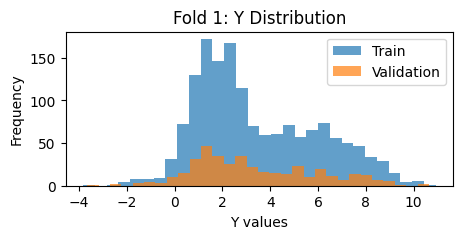

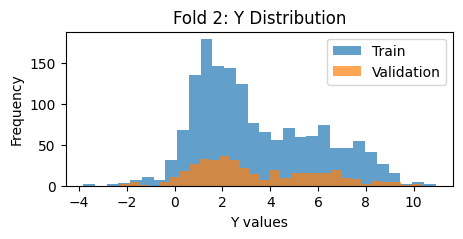

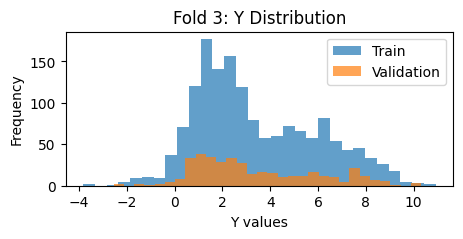

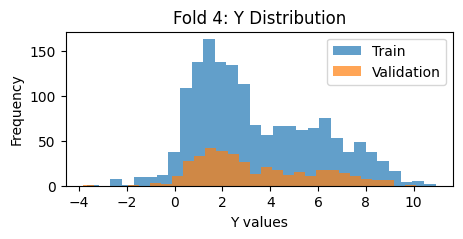

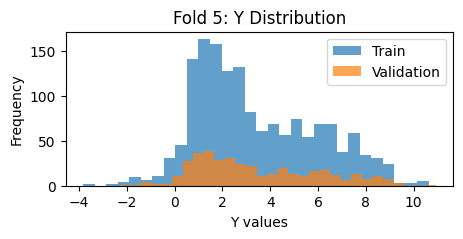

In [12]:
def pIC50_to_IC50(pic50_values):
    """Convert pIC50 values to IC50 (nM)."""
    return 10 ** (9 - pic50_values)


y = np.load(os.path.join(path_data, f"y_train.{feature_version}.npy"))
y = np.log(pIC50_to_IC50(y))

# 5-fold
n_fold = 5

# y를 구간으로 나누기
kbd = KBinsDiscretizer(n_bins=n_fold, encode='ordinal', strategy='quantile')
y_binned = kbd.fit_transform(y.reshape(-1, 1))

# StratifiedKFold 적용
skf = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=42)
# 각 fold의 y 분포를 시각화
for i, (train_index, val_index) in enumerate(skf.split(y, y_binned)):
    plt.figure(figsize=(5, 2))
    plt.hist(y[train_index], bins=30, alpha=0.7, label='Train')
    plt.hist(y[val_index], bins=30, alpha=0.7, label='Validation')
    plt.title(f'Fold {i+1}: Y Distribution')
    plt.xlabel('Y values')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

## Define Data Handler and Trainer

In [13]:
class DataHandler:
    
    def __init__(self, feature_version, path_data):
        self.feature_version = feature_version
        self.path_data = path_data
        self.fps2048_desc170 = None
        self.infomax300 = None
        self.bindaff = None
        self.y_train = None
        self.load_all_data()
        self.scaler = None

    def load_all_data(self):
        self.fps2048_desc170 = np.load(os.path.join(self.path_data, f"X_train.{feature_version}.npy"))
        self.infomax300 = np.load(os.path.join(self.path_data, "infomax300.train.npy"))
        self.load_y()

    def load_y(self):
        y = np.load(os.path.join(self.path_data, f"y_train.{feature_version}.npy"))
        self.y_train = np.log(self.pIC50_to_IC50(y))

    @staticmethod
    def pIC50_to_IC50(pic50_values):
        return 10 ** (9 - pic50_values)

    def load_data(self, is_infomax300: bool, is_fps2048_desc170: bool) -> Tuple[np.ndarray, np.ndarray]:
        if is_infomax300 and is_fps2048_desc170:
            X = np.hstack((self.fps2048_desc170, self.infomax300))
        elif is_infomax300:
            X = self.infomax300
        elif is_fps2048_desc170:
            X = self.fps2048_desc170
        else:
            raise ValueError("At least one of is_infomax300 or is_fps2048_desc170 must be True")
        
        return X, self.y_train

    def load_test_data(self, is_infomax300: bool, is_fps2048_desc170: bool) -> np.ndarray:
        fps2048_desc170_test = np.load(os.path.join(self.path_data, f"X_test.{feature_version}.npy"))
        infomax300_test = np.load(os.path.join(self.path_data, "infomax300.test.npy"))

        if is_infomax300 and is_fps2048_desc170:
            X_test = np.hstack((fps2048_desc170_test, infomax300_test))
        elif is_infomax300:
            X_test = infomax300_test
        elif is_fps2048_desc170:
            X_test = fps2048_desc170_test
        else:
            raise ValueError("At least one of is_infomax300 or is_fps2048_desc170 must be True")

        return X_test
    
    def fit_scaler(self, X: np.ndarray):
        self.scaler = StandardScaler().fit(X)

    def preprocess_data(self, X: np.ndarray, y: Optional[np.ndarray] = None) -> Tuple[torch.Tensor, Optional[torch.Tensor]]:
        if y is not None:
            return torch.FloatTensor(self.scaler.transform(X)), torch.FloatTensor(y)
        else:
            return torch.FloatTensor(self.scaler.transform(X)), None

# Model definition
class MLP(nn.Module):
    def __init__(self, input_dim: int, hidden_dims: List[int], dropout_rate: float):
        torch.manual_seed(42)
        super(MLP, self).__init__()
        layers = []
        prev_dim = input_dim
        for hidden_dim in hidden_dims:
            layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.ReLU(),
                nn.Dropout(dropout_rate)
            ])
            prev_dim = hidden_dim
        layers.append(nn.Linear(prev_dim, 1))
        self.model = nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.model(x)

# Training utilities
class EarlyStopping:
    def __init__(self, patience: int = 20, min_delta: float = 0.00005):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False

    def __call__(self, val_loss: float) -> None:
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

class Trainer:
    def __init__(self, model: nn.Module, criterion: nn.Module, optimizer: optim.Optimizer, 
                 device: torch.device):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.device = device

    def train_epoch(self, dataloader: torch.utils.data.DataLoader) -> float:
        self.model.train()
        total_loss = 0
        for X_batch, y_batch in dataloader:
            X_batch, y_batch = X_batch.to(self.device), y_batch.to(self.device)
            self.optimizer.zero_grad()
            y_pred = self.model(X_batch)
            y_batch = y_batch.view_as(y_pred)  # 차원 맞추기
            loss = self.criterion(y_pred, y_batch)
            loss.backward()
            self.optimizer.step()
            total_loss += loss.item()
        return total_loss / len(dataloader)

    def evaluate(self, dataloader: torch.utils.data.DataLoader) -> float:
        self.model.eval()
        total_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in dataloader:
                X_batch, y_batch = X_batch.to(self.device), y_batch.to(self.device)
                y_pred = self.model(X_batch)
                y_batch = y_batch.view_as(y_pred)  # 차원 맞추기
                loss = self.criterion(y_pred, y_batch)
                total_loss += loss.item()
        return total_loss / len(dataloader)

In [14]:
# DataHandler 인스턴스 생성
data_handler = DataHandler(feature_version, path_data)

## Metric Functions & Data Visualization

In [15]:
def pIC50_to_IC50(pic50_values):
    """Convert pIC50 values to IC50 (nM)."""
    return 10 ** (9 - pic50_values)
    
def log_10IC50_to_pIC50(log10_ic50_values):
    """Convert IC50 (nM) values to pIC50."""
    ic50_values = np.exp(log10_ic50_values)
    return 9 - np.log10(ic50_values)

def make_score(correct_ratio, nrmse_ic50):
    # Calculate Score
    score = 0.5 * (1 - min(nrmse_ic50, 1)) + 0.5 * correct_ratio
    return score

def make_correct_ratio(y_true_pIC50, y_pred_pIC50):
    # Calculate Absolute Errors
    absolute_errors = np.abs(y_true_pIC50 - y_pred_pIC50)

    # Count how many errors are <= 0.5
    correct_count = sum(absolute_errors <= 0.5)
    
    # Correct Ratio
    correct_ratio = correct_count / len(y_true_pIC50)
    return correct_ratio

def make_metric(y_true_log10_IC50, y_pred_log10_IC50):
    y_true_pIC50 = log_10IC50_to_pIC50(y_true_log10_IC50)
    y_pred_pIC50 = log_10IC50_to_pIC50(y_pred_log10_IC50)
    
    y_true_ic50 = pIC50_to_IC50(y_true_pIC50)
    y_pred_ic50 = pIC50_to_IC50(y_pred_pIC50)
    
    rmse_pic50 = np.sqrt(mean_squared_error(y_true_pIC50, y_pred_pIC50))
    rmse_ic50 = np.sqrt(mean_squared_error(y_true_ic50, y_pred_ic50))

    nrmse_ic50 = rmse_ic50 / (y_true_ic50.max() - y_true_ic50.min())

    mape_ic50 = np.mean(np.abs((y_true_ic50 - y_pred_ic50) / y_true_ic50)) * 100
    mape_pic50 = np.mean(np.abs((y_true_pIC50 - y_pred_pIC50) / y_true_pIC50)) * 100

    correct_ratio = make_correct_ratio(y_true_pIC50, y_pred_pIC50)
    score = make_score(correct_ratio, nrmse_ic50)

    r2_pic50 = r2_score(y_true_pIC50, y_pred_pIC50)
    r2_ic50 = r2_score(y_true_ic50, y_pred_ic50)
    
    return {
        'rmse_pic50': rmse_pic50,
        'mape_pic50' : mape_pic50,
        'r2_pic50' :r2_pic50,

        'rmse_ic50': rmse_ic50,
        'nrmse_ic50': nrmse_ic50,
        'mape_ic50': mape_ic50,
        'r2_ic50': r2_ic50,
        
        'correct_ratio': correct_ratio,
        'score': score
    }

def draw_loss_plot(train_loss, val_loss):
    epoch_list = [i for i in range(len(train_loss))]
    
    plt.figure(figsize=(10, 5))
    plt.plot(epoch_list, train_loss, label='Training Loss', color='blue')
    plt.plot(epoch_list, val_loss, label='Validation Loss', color='orange')
    
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def draw_pred(y_true_log10_IC50, y_pred_log10_IC50):
    y_true_pIC50 = log_10IC50_to_pIC50(y_true_log10_IC50)
    y_pred_pIC50 = log_10IC50_to_pIC50(y_pred_log10_IC50)
    # pIC50 값을 IC50로 변환
    y_true_ic50 = pIC50_to_IC50(y_true_pIC50) 
    y_pred_ic50 = pIC50_to_IC50(y_pred_pIC50)
 

    fig, axs = plt.subplots(1, 3, figsize=(12, 6))

    axs[0].scatter(y_true_pIC50, y_pred_pIC50, color='blue', label='Predictions')
    axs[0].plot([min(y_true_pIC50), max(y_true_pIC50)], [min(y_true_pIC50), max(y_true_pIC50)], color='red', linestyle='--', label='Ideal line')
    
    upper_bound = y_true_pIC50 + 0.5
    lower_bound = y_true_pIC50 - 0.5

    axs[0].plot(y_true_pIC50, upper_bound, color='green', linestyle=':', label='Upper bound (y_true + 0.5)')
    axs[0].plot(y_true_pIC50, lower_bound, color='green', linestyle=':', label='lower_bound bound (y_true - 0.5)')

    axs[0].set_xlabel('Ground Truth (y_true)')
    axs[0].set_ylabel('Predictions (y_pred)')
    axs[0].set_title('pIC50')
    axs[0].legend()
    axs[0].grid(True)

    axs[1].scatter(y_true_ic50, y_pred_ic50, color='blue', label='Predictions')
    axs[1].plot([min(y_true_ic50), max(y_true_ic50)], [min(y_true_ic50), max(y_true_ic50)], color='red', linestyle='--', label='Ideal line')
    
    axs[1].set_xlabel('Ground Truth (y_true)')
    axs[1].set_ylabel('Predictions (y_pred)')
    axs[1].set_title('IC50')
    axs[1].legend()
    axs[1].grid(True)

    axs[2].scatter(y_true_log10_IC50, y_pred_log10_IC50, color='blue', label='Predictions')
    axs[2].plot([min(y_true_log10_IC50), max(y_true_log10_IC50)], [min(y_true_log10_IC50), max(y_true_log10_IC50)], color='red', linestyle='--', label='Ideal line')
    
    axs[2].set_xlabel('Ground Truth (y_true)')
    axs[2].set_ylabel('Predictions (y_pred)')
    axs[2].set_title('log(IC50)')
    axs[2].legend()
    axs[2].grid(True)

    plt.tight_layout()
    plt.show()

## Optuna / Hyperparameter Optimization

In [16]:
def objective(trial: optuna.Trial) -> float:

    print()
    print("=" * 120)
    print(f"Trial #{trial.number:02d}")
    
    # Hyperparameter settings
    params = {
        'num_layers': trial.suggest_int('num_layers', 2, 5),
        'layer_ratio': trial.suggest_float('layer_ratio', 0.4, 0.8),
        'batch_size': trial.suggest_categorical('batch_size', [32, 64, 128]),
        'learning_rate': trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True),
        'dropout_rate': trial.suggest_categorical('dropout_rate',[0.3, 0.5]),
        'is_infomax300': trial.suggest_categorical('infomax300', [True, False]),
        'is_fps2048_desc170': trial.suggest_categorical('fps2048_desc170', [True, False])
    }

    # 두 특성 집합 중 하나는 반드시 사용되도록 함
    if not params['is_infomax300'] and not params['is_fps2048_desc170']:
        params['is_infomax300'] = True

    print("Hyperparameters:")
    print(json.dumps(params, indent=4))

    X, y = data_handler.load_data(params['is_infomax300'], params['is_fps2048_desc170'])

    n_fold = 5
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    kfold = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=42)
    y_binned = KBinsDiscretizer(n_bins=n_fold, encode='ordinal', strategy='quantile').fit_transform(y.reshape(-1, 1))
    fold_metrics = []

    for fold, (train_idx, val_idx) in enumerate(kfold.split(X, y_binned)):
        with mlflow.start_run(experiment_id=experiment_id, run_name=f"trial_{trial.number:02d}_fold_{fold+1:02d}"):
            
            mlflow.log_params(params)
            
            X_train, X_val = X[train_idx], X[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]
            
            data_handler.fit_scaler(X_train)
            X_train_scaled, y_train = data_handler.preprocess_data(X_train, y_train)
            X_val_scaled, y_val = data_handler.preprocess_data(X_val, y_val)

            train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_train_scaled, y_train), 
                                                    batch_size=params['batch_size'], shuffle=True)
            val_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_val_scaled, y_val), 
                                                    batch_size=params['batch_size'])

            input_dim = X.shape[1]
            hidden_dims = [int(input_dim * (1 - (1 - params['layer_ratio']) * i / params['num_layers'])) 
                        for i in range(1, params['num_layers'])]

            model = MLP(input_dim, hidden_dims, params['dropout_rate']).to(device)
            criterion = nn.MSELoss()
            optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'])

            trainer = Trainer(model, criterion, optimizer, device)
            early_stopping = EarlyStopping()

            train_loss = []
            val_loss = []
            for epoch in range(300):
                train_loss.append(trainer.train_epoch(train_loader))
                val_loss.append(trainer.evaluate(val_loader))

                if (epoch + 1) % 100 == 0:
                    print(f'Fold {fold + 1}, Epoch {epoch + 1}: Train loss: {train_loss[-1]:.4f}, Val loss: {val_loss[-1]:.4f}')

                early_stopping(val_loss[-1])
                if early_stopping.early_stop:
                    print(f'Fold {fold + 1}: Early stopping triggered at epoch {epoch + 1}')
                    break

            model.eval()
            y_val_pred = model(X_val_scaled.to(device)).detach().cpu().numpy().reshape(-1,)
            fold_metrics.append(make_metric(y_val.numpy(), y_val_pred))

            print(f'Fold {fold + 1}: '
                f'RMSE_PIC50: {fold_metrics[-1]["rmse_pic50"]:.4f}, '
                f'MAPE_PIC50: {fold_metrics[-1]["mape_pic50"]:.4f}, '                
                f'RMSE_IC50: {fold_metrics[-1]["rmse_ic50"]:.4f}, '
                f'NRMSE_IC50: {fold_metrics[-1]["nrmse_ic50"]:.4f}, '
                f'MAPE_IC50: {fold_metrics[-1]["mape_ic50"]:.4f}, '
                f'Correct Ratio: {fold_metrics[-1]["correct_ratio"]:.4f}, '
                f'Score: {fold_metrics[-1]["score"]:.4f}')
            
            for key, value in fold_metrics[-1].items():
                mlflow.log_metric(f"{key}", value)
            
            df_submit = pd.read_csv("./sample_submission.csv")
            folder_path_out = './' + experiment_name +'/'+ 'trial' + str(trial.number)
            
            os.makedirs(folder_path_out, exist_ok=True)

            X_test = data_handler.load_test_data(params['is_infomax300'], params['is_fps2048_desc170'])

            X_test_scaled, _ = data_handler.preprocess_data(X_test)
            y_pred = model(X_test_scaled.to(device)).detach().cpu().numpy().reshape(-1,)
            
            df_submit['IC50_nM'] = np.exp(y_pred)
            df_submit.to_csv(os.path.join(folder_path_out, f'fold{fold+1}.csv'), index=False)
            torch.save(model.state_dict(), os.path.join(folder_path_out, f'fold{fold+1}.pth'))

            current_nrmse = fold_metrics[-1]["nrmse_ic50"]
            if current_nrmse < trial.study.user_attrs.get('best_nrmse', float('inf')):
                trial.study.set_user_attr('best_nrmse', current_nrmse)
                trial.study.set_user_attr('best_model_state', model.state_dict())
                trial.study.set_user_attr('best_is_infomax300', params['is_infomax300'])
                trial.study.set_user_attr('best_is_fps2048_desc170', params['is_fps2048_desc170'])
                trial.study.set_user_attr('best_fold', fold)
                trial.study.set_user_attr('best_input_dim', input_dim)
                trial.study.set_user_attr('best_hidden_dims', hidden_dims)
                trial.study.set_user_attr('best_dropout_rate', params['dropout_rate'])

    avg_metrics = {k: np.mean([m[k] for m in fold_metrics]) for k in fold_metrics[0]}
    print('Mean metrics:')
    # print(json.dumps(avg_metrics, indent=4))
    for key, value in avg_metrics.items():
        print(f'{key}: {value:.4f}')

    return avg_metrics['nrmse_ic50']

# Main execution
if __name__ == "__main__":
    study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=42))
    study.optimize(objective, n_trials=30)

    print("Best hyperparameters:", study.best_params)
    print("Best RMSE:", study.best_value)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # 최적 모델 로드
    best_input_dim = study.user_attrs['best_input_dim']
    best_hidden_dims = study.user_attrs['best_hidden_dims']
    best_dropout_rate = study.user_attrs['best_dropout_rate']
    best_model = MLP(best_input_dim, best_hidden_dims, best_dropout_rate).to(device)
    best_model.load_state_dict(study.user_attrs['best_model_state'])
    best_model.eval()
    
    is_infomax300_best_fold = study.user_attrs['best_is_infomax300']
    is_fps2048_desc170_best_fold = study.user_attrs['best_is_fps2048_desc170']

    X, y = data_handler.load_data(is_infomax300_best_fold, is_fps2048_desc170_best_fold)
    n_fold = 5
    kfold = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=42)
    y_binned = KBinsDiscretizer(n_bins=n_fold, encode='ordinal', strategy='quantile').fit_transform(y.reshape(-1, 1))

    # 최적 fold에 해당하는 train set 생성
    train_idx, val_idx = list(kfold.split(X, y_binned))[study.user_attrs['best_fold']]
    X_train, X_val = X[train_idx], X[val_idx]
    data_handler.fit_scaler(X_train)

    X_test = data_handler.load_test_data(is_infomax300_best_fold, is_fps2048_desc170_best_fold)
    X_test_scaled, _ = data_handler.preprocess_data(X_test)
    y_pred = best_model(X_test_scaled.to(device)).detach().cpu().numpy().reshape(-1,)

    df_submit = pd.read_csv("./sample_submission.csv")
    df_submit['IC50_nM'] = np.exp(y_pred)
    df_submit.to_csv('./submission.csv', index=False)

[I 2024-10-04 05:27:09,272] A new study created in memory with name: no-name-ba6b9c88-8682-491f-a0bd-0db138c48a60



Trial #00
Hyperparameters:
{
    "num_layers": 3,
    "layer_ratio": 0.7802857225639666,
    "batch_size": 32,
    "learning_rate": 2.9375384576328295e-05,
    "dropout_rate": 0.5,
    "is_infomax300": true,
    "is_fps2048_desc170": false
}
Fold 1, Epoch 100: Train loss: 1.8343, Val loss: 3.0176
Fold 1, Epoch 200: Train loss: 1.3094, Val loss: 2.7586
Fold 1: Early stopping triggered at epoch 205
Fold 1: RMSE_PIC50: 0.6628, MAPE_PIC50: 6.9496, RMSE_IC50: 2930.4678, NRMSE_IC50: 0.0703, MAPE_IC50: 355.2621, Correct Ratio: 0.6368, Score: 0.7833
Fold 2, Epoch 100: Train loss: 1.7785, Val loss: 2.8894
Fold 2, Epoch 200: Train loss: 1.3317, Val loss: 2.8299
Fold 2: Early stopping triggered at epoch 208
Fold 2: RMSE_PIC50: 0.5924, MAPE_PIC50: 6.2715, RMSE_IC50: 2241.7336, NRMSE_IC50: 0.0742, MAPE_IC50: 216.0107, Correct Ratio: 0.6650, Score: 0.7954
Fold 3, Epoch 100: Train loss: 1.8025, Val loss: 2.7259
Fold 3, Epoch 200: Train loss: 1.3133, Val loss: 2.4917
Fold 3, Epoch 300: Train loss: 1.

[I 2024-10-04 05:27:58,295] Trial 0 finished with value: 0.06936180591583252 and parameters: {'num_layers': 3, 'layer_ratio': 0.7802857225639666, 'batch_size': 32, 'learning_rate': 2.9375384576328295e-05, 'dropout_rate': 0.5, 'infomax300': False, 'fps2048_desc170': False}. Best is trial 0 with value: 0.06936180591583252.


Fold 5, Epoch 300: Train loss: 1.0608, Val loss: 3.4786
Fold 5: RMSE_PIC50: 0.6950, MAPE_PIC50: 7.0781, RMSE_IC50: 3362.7200, NRMSE_IC50: 0.0612, MAPE_IC50: 475.8710, Correct Ratio: 0.6615, Score: 0.8002
Mean metrics:
rmse_pic50: 0.6283
mape_pic50: 6.5296
r2_pic50: 0.6774
rmse_ic50: 2490.5066
nrmse_ic50: 0.0694
mape_ic50: 341.2257
r2_ic50: 0.0897
correct_ratio: 0.6568
score: 0.7937

Trial #01
Hyperparameters:
{
    "num_layers": 5,
    "layer_ratio": 0.4849356442713105,
    "batch_size": 128,
    "learning_rate": 0.00037520558551242813,
    "dropout_rate": 0.3,
    "is_infomax300": true,
    "is_fps2048_desc170": false
}
Fold 1: Early stopping triggered at epoch 51
Fold 1: RMSE_PIC50: 0.6679, MAPE_PIC50: 6.9828, RMSE_IC50: 2898.7722, NRMSE_IC50: 0.0695, MAPE_IC50: 203.6271, Correct Ratio: 0.6701, Score: 0.8003
Fold 2: Early stopping triggered at epoch 69
Fold 2: RMSE_PIC50: 0.5882, MAPE_PIC50: 6.1907, RMSE_IC50: 2338.2891, NRMSE_IC50: 0.0774, MAPE_IC50: 168.9548, Correct Ratio: 0.6675,

[I 2024-10-04 05:28:06,564] Trial 1 finished with value: 0.07299523055553436 and parameters: {'num_layers': 5, 'layer_ratio': 0.4849356442713105, 'batch_size': 128, 'learning_rate': 0.00037520558551242813, 'dropout_rate': 0.3, 'infomax300': True, 'fps2048_desc170': False}. Best is trial 0 with value: 0.06936180591583252.


Fold 5: Early stopping triggered at epoch 57
Fold 5: RMSE_PIC50: 0.7022, MAPE_PIC50: 7.2473, RMSE_IC50: 3245.9055, NRMSE_IC50: 0.0591, MAPE_IC50: 358.4811, Correct Ratio: 0.6205, Score: 0.7807
Mean metrics:
rmse_pic50: 0.6371
mape_pic50: 6.6277
r2_pic50: 0.6683
rmse_ic50: 2578.7209
nrmse_ic50: 0.0730
mape_ic50: 271.7227
r2_ic50: 0.0064
correct_ratio: 0.6696
score: 0.7983

Trial #02
Hyperparameters:
{
    "num_layers": 3,
    "layer_ratio": 0.7140703845572055,
    "batch_size": 128,
    "learning_rate": 1.3783237455007187e-05,
    "dropout_rate": 0.3,
    "is_infomax300": false,
    "is_fps2048_desc170": true
}
Fold 1: Early stopping triggered at epoch 95
Fold 1: RMSE_PIC50: 0.6557, MAPE_PIC50: 6.7865, RMSE_IC50: 2796.0183, NRMSE_IC50: 0.0671, MAPE_IC50: 299.8468, Correct Ratio: 0.6496, Score: 0.7913
Fold 2: Early stopping triggered at epoch 71
Fold 2: RMSE_PIC50: 0.6160, MAPE_PIC50: 6.1544, RMSE_IC50: 2100.0820, NRMSE_IC50: 0.0695, MAPE_IC50: 269.3919, Correct Ratio: 0.6777, Score: 0.8

[I 2024-10-04 05:30:38,952] Trial 2 finished with value: 0.06659410893917084 and parameters: {'num_layers': 3, 'layer_ratio': 0.7140703845572055, 'batch_size': 128, 'learning_rate': 1.3783237455007187e-05, 'dropout_rate': 0.3, 'infomax300': False, 'fps2048_desc170': True}. Best is trial 2 with value: 0.06659410893917084.


Fold 5: Early stopping triggered at epoch 58
Fold 5: RMSE_PIC50: 0.6814, MAPE_PIC50: 7.0138, RMSE_IC50: 3153.5784, NRMSE_IC50: 0.0574, MAPE_IC50: 359.9311, Correct Ratio: 0.6615, Score: 0.8021
Mean metrics:
rmse_pic50: 0.6443
mape_pic50: 6.5070
r2_pic50: 0.6606
rmse_ic50: 2382.3145
nrmse_ic50: 0.0666
mape_ic50: 446.1365
r2_ic50: 0.1652
correct_ratio: 0.6634
score: 0.7984

Trial #03
Hyperparameters:
{
    "num_layers": 3,
    "layer_ratio": 0.43906884560255355,
    "batch_size": 32,
    "learning_rate": 0.0003058656666978527,
    "dropout_rate": 0.5,
    "is_infomax300": true,
    "is_fps2048_desc170": false
}
Fold 1: Early stopping triggered at epoch 72
Fold 1: RMSE_PIC50: 0.6523, MAPE_PIC50: 6.6697, RMSE_IC50: 3029.2026, NRMSE_IC50: 0.0727, MAPE_IC50: 310.2558, Correct Ratio: 0.6496, Score: 0.7885
Fold 2: Early stopping triggered at epoch 79
Fold 2: RMSE_PIC50: 0.6010, MAPE_PIC50: 6.3296, RMSE_IC50: 2281.8811, NRMSE_IC50: 0.0756, MAPE_IC50: 178.2353, Correct Ratio: 0.6726, Score: 0.79

[I 2024-10-04 05:30:53,852] Trial 3 finished with value: 0.07758769392967224 and parameters: {'num_layers': 3, 'layer_ratio': 0.43906884560255355, 'batch_size': 32, 'learning_rate': 0.0003058656666978527, 'dropout_rate': 0.5, 'infomax300': False, 'fps2048_desc170': False}. Best is trial 2 with value: 0.06659410893917084.


Fold 5: Early stopping triggered at epoch 118
Fold 5: RMSE_PIC50: 0.7111, MAPE_PIC50: 7.1457, RMSE_IC50: 5484.2456, NRMSE_IC50: 0.0998, MAPE_IC50: 479.1285, Correct Ratio: 0.6667, Score: 0.7834
Mean metrics:
rmse_pic50: 0.6320
mape_pic50: 6.5151
r2_pic50: 0.6735
rmse_ic50: 2933.9043
nrmse_ic50: 0.0776
mape_ic50: 311.3677
r2_ic50: -0.2763
correct_ratio: 0.6701
score: 0.7963

Trial #04
Hyperparameters:
{
    "num_layers": 4,
    "layer_ratio": 0.4739417822102108,
    "batch_size": 32,
    "learning_rate": 0.004835952776465951,
    "dropout_rate": 0.5,
    "is_infomax300": true,
    "is_fps2048_desc170": false
}
Fold 1: Early stopping triggered at epoch 28
Fold 1: RMSE_PIC50: 0.7965, MAPE_PIC50: 8.7015, RMSE_IC50: 2959.5701, NRMSE_IC50: 0.0710, MAPE_IC50: 362.4197, Correct Ratio: 0.5652, Score: 0.7471
Fold 2: Early stopping triggered at epoch 29
Fold 2: RMSE_PIC50: 0.7434, MAPE_PIC50: 8.3322, RMSE_IC50: 2372.5122, NRMSE_IC50: 0.0786, MAPE_IC50: 182.2522, Correct Ratio: 0.5627, Score: 0.74

[I 2024-10-04 05:31:02,924] Trial 4 finished with value: 0.0746002197265625 and parameters: {'num_layers': 4, 'layer_ratio': 0.4739417822102108, 'batch_size': 32, 'learning_rate': 0.004835952776465951, 'dropout_rate': 0.5, 'infomax300': False, 'fps2048_desc170': False}. Best is trial 2 with value: 0.06659410893917084.


Fold 5: Early stopping triggered at epoch 33
Fold 5: RMSE_PIC50: 0.8078, MAPE_PIC50: 8.9519, RMSE_IC50: 3698.8921, NRMSE_IC50: 0.0673, MAPE_IC50: 238.1543, Correct Ratio: 0.5590, Score: 0.7458
Mean metrics:
rmse_pic50: 0.7367
mape_pic50: 8.1192
r2_pic50: 0.5561
rmse_ic50: 2671.8022
nrmse_ic50: 0.0746
mape_ic50: 261.8945
r2_ic50: -0.0530
correct_ratio: 0.5804
score: 0.7529

Trial #05
Hyperparameters:
{
    "num_layers": 3,
    "layer_ratio": 0.5085396127095584,
    "batch_size": 32,
    "learning_rate": 0.00042470585622618684,
    "dropout_rate": 0.5,
    "is_infomax300": false,
    "is_fps2048_desc170": true
}
Fold 1: Early stopping triggered at epoch 27
Fold 1: RMSE_PIC50: 0.6900, MAPE_PIC50: 7.2764, RMSE_IC50: 2913.6162, NRMSE_IC50: 0.0699, MAPE_IC50: 269.0933, Correct Ratio: 0.6189, Score: 0.7745
Fold 2: Early stopping triggered at epoch 25
Fold 2: RMSE_PIC50: 0.6314, MAPE_PIC50: 6.4819, RMSE_IC50: 2249.4373, NRMSE_IC50: 0.0745, MAPE_IC50: 185.5499, Correct Ratio: 0.6931, Score: 0.8

[I 2024-10-04 05:33:00,463] Trial 5 finished with value: 0.06943178176879883 and parameters: {'num_layers': 3, 'layer_ratio': 0.5085396127095584, 'batch_size': 32, 'learning_rate': 0.00042470585622618684, 'dropout_rate': 0.5, 'infomax300': False, 'fps2048_desc170': True}. Best is trial 2 with value: 0.06659410893917084.


Fold 5: Early stopping triggered at epoch 25
Fold 5: RMSE_PIC50: 0.7200, MAPE_PIC50: 6.9112, RMSE_IC50: 3514.3435, NRMSE_IC50: 0.0640, MAPE_IC50: 1477.8273, Correct Ratio: 0.6872, Score: 0.8116
Mean metrics:
rmse_pic50: 0.6669
mape_pic50: 6.7858
r2_pic50: 0.6366
rmse_ic50: 2510.8743
nrmse_ic50: 0.0694
mape_ic50: 671.4066
r2_ic50: 0.0837
correct_ratio: 0.6634
score: 0.7970

Trial #06
Hyperparameters:
{
    "num_layers": 2,
    "layer_ratio": 0.7261845713819337,
    "batch_size": 128,
    "learning_rate": 1.6677615430197892e-05,
    "dropout_rate": 0.3,
    "is_infomax300": true,
    "is_fps2048_desc170": true
}
Fold 1, Epoch 100: Train loss: 0.3675, Val loss: 4.1678
Fold 1: Early stopping triggered at epoch 122
Fold 1: RMSE_PIC50: 0.6988, MAPE_PIC50: 7.5009, RMSE_IC50: 2880.4458, NRMSE_IC50: 0.0691, MAPE_IC50: 169.8871, Correct Ratio: 0.6164, Score: 0.7736
Fold 2, Epoch 100: Train loss: 0.3646, Val loss: 5.4576
Fold 2, Epoch 200: Train loss: 0.1809, Val loss: 5.2323
Fold 2: Early stoppi

[I 2024-10-04 05:36:19,008] Trial 6 finished with value: 0.06866425275802612 and parameters: {'num_layers': 2, 'layer_ratio': 0.7261845713819337, 'batch_size': 128, 'learning_rate': 1.6677615430197892e-05, 'dropout_rate': 0.3, 'infomax300': True, 'fps2048_desc170': True}. Best is trial 2 with value: 0.06659410893917084.


Fold 5: Early stopping triggered at epoch 250
Fold 5: RMSE_PIC50: 0.7618, MAPE_PIC50: 7.9067, RMSE_IC50: 3120.7456, NRMSE_IC50: 0.0568, MAPE_IC50: 316.4521, Correct Ratio: 0.6205, Score: 0.7819
Mean metrics:
rmse_pic50: 0.6958
mape_pic50: 7.1593
r2_pic50: 0.6046
rmse_ic50: 2446.6316
nrmse_ic50: 0.0687
mape_ic50: 272.4246
r2_ic50: 0.1179
correct_ratio: 0.6435
score: 0.7874

Trial #07
Hyperparameters:
{
    "num_layers": 3,
    "layer_ratio": 0.5300733288106988,
    "batch_size": 128,
    "learning_rate": 0.00026100256506134736,
    "dropout_rate": 0.5,
    "is_infomax300": true,
    "is_fps2048_desc170": true
}
Fold 1: Early stopping triggered at epoch 85
Fold 1: RMSE_PIC50: 0.6758, MAPE_PIC50: 6.9363, RMSE_IC50: 2728.5198, NRMSE_IC50: 0.0655, MAPE_IC50: 284.4457, Correct Ratio: 0.6087, Score: 0.7716
Fold 2: Early stopping triggered at epoch 23
Fold 2: RMSE_PIC50: 0.6199, MAPE_PIC50: 6.4305, RMSE_IC50: 2234.8899, NRMSE_IC50: 0.0740, MAPE_IC50: 221.2794, Correct Ratio: 0.6803, Score: 0.8

[I 2024-10-04 05:37:45,900] Trial 7 finished with value: 0.06722871959209442 and parameters: {'num_layers': 3, 'layer_ratio': 0.5300733288106988, 'batch_size': 128, 'learning_rate': 0.00026100256506134736, 'dropout_rate': 0.5, 'infomax300': True, 'fps2048_desc170': True}. Best is trial 2 with value: 0.06659410893917084.


Fold 5: Early stopping triggered at epoch 33
Fold 5: RMSE_PIC50: 0.7010, MAPE_PIC50: 7.0469, RMSE_IC50: 3430.5010, NRMSE_IC50: 0.0624, MAPE_IC50: 382.0858, Correct Ratio: 0.6667, Score: 0.8021
Mean metrics:
rmse_pic50: 0.6511
mape_pic50: 6.6766
r2_pic50: 0.6541
rmse_ic50: 2430.6379
nrmse_ic50: 0.0672
mape_ic50: 329.1390
r2_ic50: 0.1414
correct_ratio: 0.6588
score: 0.7958

Trial #08
Hyperparameters:
{
    "num_layers": 4,
    "layer_ratio": 0.5710164073434199,
    "batch_size": 64,
    "learning_rate": 0.0008113929572637835,
    "dropout_rate": 0.5,
    "is_infomax300": true,
    "is_fps2048_desc170": false
}
Fold 1: Early stopping triggered at epoch 45
Fold 1: RMSE_PIC50: 0.6666, MAPE_PIC50: 7.0169, RMSE_IC50: 2853.1621, NRMSE_IC50: 0.0684, MAPE_IC50: 205.5264, Correct Ratio: 0.6598, Score: 0.7957
Fold 2: Early stopping triggered at epoch 54
Fold 2: RMSE_PIC50: 0.6191, MAPE_PIC50: 6.4805, RMSE_IC50: 2263.0027, NRMSE_IC50: 0.0749, MAPE_IC50: 117.8834, Correct Ratio: 0.6624, Score: 0.793

[I 2024-10-04 05:37:56,353] Trial 8 finished with value: 0.07090844959020615 and parameters: {'num_layers': 4, 'layer_ratio': 0.5710164073434199, 'batch_size': 64, 'learning_rate': 0.0008113929572637835, 'dropout_rate': 0.5, 'infomax300': True, 'fps2048_desc170': False}. Best is trial 2 with value: 0.06659410893917084.


Fold 5: Early stopping triggered at epoch 51
Fold 5: RMSE_PIC50: 0.7598, MAPE_PIC50: 8.0491, RMSE_IC50: 3277.6692, NRMSE_IC50: 0.0596, MAPE_IC50: 247.5125, Correct Ratio: 0.6051, Score: 0.7727
Mean metrics:
rmse_pic50: 0.6574
mape_pic50: 6.8819
r2_pic50: 0.6462
rmse_ic50: 2520.7341
nrmse_ic50: 0.0709
mape_ic50: 259.4306
r2_ic50: 0.0589
correct_ratio: 0.6573
score: 0.7932

Trial #09
Hyperparameters:
{
    "num_layers": 2,
    "layer_ratio": 0.4307919639315172,
    "batch_size": 128,
    "learning_rate": 0.002656813924114493,
    "dropout_rate": 0.5,
    "is_infomax300": true,
    "is_fps2048_desc170": true
}
Fold 1: Early stopping triggered at epoch 29
Fold 1: RMSE_PIC50: 1.5559, MAPE_PIC50: 17.7558, RMSE_IC50: 47809.6562, NRMSE_IC50: 1.1469, MAPE_IC50: 217.1325, Correct Ratio: 0.2379, Score: 0.1189
Fold 2: Early stopping triggered at epoch 23
Fold 2: RMSE_PIC50: 1.9036, MAPE_PIC50: 20.5204, RMSE_IC50: 201938848.0000, NRMSE_IC50: 6686.8457, MAPE_IC50: 54820176.0000, Correct Ratio: 0.163

[I 2024-10-04 05:38:18,164] Trial 9 finished with value: 2001.081787109375 and parameters: {'num_layers': 2, 'layer_ratio': 0.4307919639315172, 'batch_size': 128, 'learning_rate': 0.002656813924114493, 'dropout_rate': 0.5, 'infomax300': True, 'fps2048_desc170': True}. Best is trial 2 with value: 0.06659410893917084.


Fold 5: Early stopping triggered at epoch 23
Fold 5: RMSE_PIC50: 1.2756, MAPE_PIC50: 13.5400, RMSE_IC50: 182277760.0000, NRMSE_IC50: 3316.9177, MAPE_IC50: 204005.9844, Correct Ratio: 0.3282, Score: 0.1641
Mean metrics:
rmse_pic50: 1.5255
mape_pic50: 16.2626
r2_pic50: -0.9405
rmse_ic50: 76855472.0000
nrmse_ic50: 2001.0818
mape_ic50: 11005146.0000
r2_ic50: -2090980718.1801
correct_ratio: 0.2721
score: 0.2862

Trial #10
Hyperparameters:
{
    "num_layers": 5,
    "layer_ratio": 0.6699188271527112,
    "batch_size": 64,
    "learning_rate": 5.6088779851586325e-05,
    "dropout_rate": 0.3,
    "is_infomax300": false,
    "is_fps2048_desc170": true
}
Fold 1: Early stopping triggered at epoch 37
Fold 1: RMSE_PIC50: 0.6940, MAPE_PIC50: 7.4283, RMSE_IC50: 2834.7878, NRMSE_IC50: 0.0680, MAPE_IC50: 178.3248, Correct Ratio: 0.6138, Score: 0.7729
Fold 2: Early stopping triggered at epoch 39
Fold 2: RMSE_PIC50: 0.6546, MAPE_PIC50: 6.8751, RMSE_IC50: 2289.6226, NRMSE_IC50: 0.0758, MAPE_IC50: 144.4176

[I 2024-10-04 05:42:04,287] Trial 10 finished with value: 0.06921990215778351 and parameters: {'num_layers': 5, 'layer_ratio': 0.6699188271527112, 'batch_size': 64, 'learning_rate': 5.6088779851586325e-05, 'dropout_rate': 0.3, 'infomax300': False, 'fps2048_desc170': True}. Best is trial 2 with value: 0.06659410893917084.


Fold 5: Early stopping triggered at epoch 66
Fold 5: RMSE_PIC50: 0.7190, MAPE_PIC50: 7.4118, RMSE_IC50: 3233.7852, NRMSE_IC50: 0.0588, MAPE_IC50: 335.4213, Correct Ratio: 0.6385, Score: 0.7898
Mean metrics:
rmse_pic50: 0.6707
mape_pic50: 7.0212
r2_pic50: 0.6330
rmse_ic50: 2470.7488
nrmse_ic50: 0.0692
mape_ic50: 280.9415
r2_ic50: 0.1016
correct_ratio: 0.6465
score: 0.7887

Trial #11
Hyperparameters:
{
    "num_layers": 3,
    "layer_ratio": 0.6168405718641451,
    "batch_size": 128,
    "learning_rate": 6.954771451368792e-05,
    "dropout_rate": 0.3,
    "is_infomax300": true,
    "is_fps2048_desc170": true
}
Fold 1: Early stopping triggered at epoch 49
Fold 1: RMSE_PIC50: 0.6531, MAPE_PIC50: 6.7756, RMSE_IC50: 2785.0122, NRMSE_IC50: 0.0668, MAPE_IC50: 220.5375, Correct Ratio: 0.6368, Score: 0.7850
Fold 2: Early stopping triggered at epoch 40
Fold 2: RMSE_PIC50: 0.5968, MAPE_PIC50: 6.0324, RMSE_IC50: 2164.3049, NRMSE_IC50: 0.0717, MAPE_IC50: 234.5696, Correct Ratio: 0.6854, Score: 0.806

[I 2024-10-04 05:43:45,930] Trial 11 finished with value: 0.06780323386192322 and parameters: {'num_layers': 3, 'layer_ratio': 0.6168405718641451, 'batch_size': 128, 'learning_rate': 6.954771451368792e-05, 'dropout_rate': 0.3, 'infomax300': True, 'fps2048_desc170': True}. Best is trial 2 with value: 0.06659410893917084.


Fold 5: Early stopping triggered at epoch 46
Fold 5: RMSE_PIC50: 0.6761, MAPE_PIC50: 6.7132, RMSE_IC50: 3367.2932, NRMSE_IC50: 0.0613, MAPE_IC50: 457.6378, Correct Ratio: 0.6821, Score: 0.8104
Mean metrics:
rmse_pic50: 0.6319
mape_pic50: 6.4256
r2_pic50: 0.6740
rmse_ic50: 2433.8696
nrmse_ic50: 0.0678
mape_ic50: 363.2670
r2_ic50: 0.1265
correct_ratio: 0.6742
score: 0.8032

Trial #12
Hyperparameters:
{
    "num_layers": 2,
    "layer_ratio": 0.569863222564676,
    "batch_size": 128,
    "learning_rate": 1.141316279684447e-05,
    "dropout_rate": 0.3,
    "is_infomax300": true,
    "is_fps2048_desc170": true
}
Fold 1, Epoch 100: Train loss: 0.4675, Val loss: 4.1244
Fold 1, Epoch 200: Train loss: 0.2278, Val loss: 3.9190
Fold 1: Early stopping triggered at epoch 206
Fold 1: RMSE_PIC50: 0.6888, MAPE_PIC50: 7.2988, RMSE_IC50: 2864.7903, NRMSE_IC50: 0.0687, MAPE_IC50: 173.6245, Correct Ratio: 0.6240, Score: 0.7777
Fold 2, Epoch 100: Train loss: 0.5523, Val loss: 5.2199
Fold 2, Epoch 200: Trai

[I 2024-10-04 05:47:36,438] Trial 12 finished with value: 0.06827415525913239 and parameters: {'num_layers': 2, 'layer_ratio': 0.569863222564676, 'batch_size': 128, 'learning_rate': 1.141316279684447e-05, 'dropout_rate': 0.3, 'infomax300': True, 'fps2048_desc170': True}. Best is trial 2 with value: 0.06659410893917084.


Fold 5: Early stopping triggered at epoch 258
Fold 5: RMSE_PIC50: 0.7490, MAPE_PIC50: 7.7782, RMSE_IC50: 3170.5479, NRMSE_IC50: 0.0577, MAPE_IC50: 305.3621, Correct Ratio: 0.6359, Score: 0.7891
Mean metrics:
rmse_pic50: 0.6824
mape_pic50: 7.0117
r2_pic50: 0.6196
rmse_ic50: 2439.2874
nrmse_ic50: 0.0683
mape_ic50: 285.6941
r2_ic50: 0.1253
correct_ratio: 0.6511
score: 0.7914

Trial #13
Hyperparameters:
{
    "num_layers": 4,
    "layer_ratio": 0.6515381879956057,
    "batch_size": 128,
    "learning_rate": 0.00011038251665362917,
    "dropout_rate": 0.3,
    "is_infomax300": false,
    "is_fps2048_desc170": true
}
Fold 1: Early stopping triggered at epoch 93
Fold 1: RMSE_PIC50: 0.6814, MAPE_PIC50: 7.0960, RMSE_IC50: 2799.8953, NRMSE_IC50: 0.0672, MAPE_IC50: 273.0883, Correct Ratio: 0.6266, Score: 0.7797
Fold 2: Early stopping triggered at epoch 26
Fold 2: RMSE_PIC50: 0.6209, MAPE_PIC50: 6.2993, RMSE_IC50: 2319.0591, NRMSE_IC50: 0.0768, MAPE_IC50: 190.6472, Correct Ratio: 0.6957, Score: 0.

[I 2024-10-04 05:50:02,827] Trial 13 finished with value: 0.06716694682836533 and parameters: {'num_layers': 4, 'layer_ratio': 0.6515381879956057, 'batch_size': 128, 'learning_rate': 0.00011038251665362917, 'dropout_rate': 0.3, 'infomax300': False, 'fps2048_desc170': True}. Best is trial 2 with value: 0.06659410893917084.


Fold 5: Early stopping triggered at epoch 28
Fold 5: RMSE_PIC50: 0.7313, MAPE_PIC50: 7.5342, RMSE_IC50: 3268.2927, NRMSE_IC50: 0.0595, MAPE_IC50: 278.3864, Correct Ratio: 0.6410, Score: 0.7908
Mean metrics:
rmse_pic50: 0.6602
mape_pic50: 6.7766
r2_pic50: 0.6435
rmse_ic50: 2411.4172
nrmse_ic50: 0.0672
mape_ic50: 325.9147
r2_ic50: 0.1430
correct_ratio: 0.6583
score: 0.7956

Trial #14
Hyperparameters:
{
    "num_layers": 4,
    "layer_ratio": 0.6668982441914542,
    "batch_size": 128,
    "learning_rate": 8.036737380362637e-05,
    "dropout_rate": 0.3,
    "is_infomax300": false,
    "is_fps2048_desc170": true
}
Fold 1: Early stopping triggered at epoch 45
Fold 1: RMSE_PIC50: 0.6731, MAPE_PIC50: 7.0167, RMSE_IC50: 2830.6433, NRMSE_IC50: 0.0679, MAPE_IC50: 253.8989, Correct Ratio: 0.6266, Score: 0.7793
Fold 2: Early stopping triggered at epoch 31
Fold 2: RMSE_PIC50: 0.6294, MAPE_PIC50: 6.3958, RMSE_IC50: 2176.5256, NRMSE_IC50: 0.0721, MAPE_IC50: 198.8633, Correct Ratio: 0.6829, Score: 0.80

[I 2024-10-04 05:52:02,677] Trial 14 finished with value: 0.06703434884548187 and parameters: {'num_layers': 4, 'layer_ratio': 0.6668982441914542, 'batch_size': 128, 'learning_rate': 8.036737380362637e-05, 'dropout_rate': 0.3, 'infomax300': False, 'fps2048_desc170': True}. Best is trial 2 with value: 0.06659410893917084.


Fold 5: Early stopping triggered at epoch 27
Fold 5: RMSE_PIC50: 0.7103, MAPE_PIC50: 7.2917, RMSE_IC50: 3261.5923, NRMSE_IC50: 0.0594, MAPE_IC50: 335.6985, Correct Ratio: 0.6769, Score: 0.8088
Mean metrics:
rmse_pic50: 0.6557
mape_pic50: 6.7144
r2_pic50: 0.6487
rmse_ic50: 2411.1538
nrmse_ic50: 0.0670
mape_ic50: 353.4039
r2_ic50: 0.1509
correct_ratio: 0.6634
score: 0.7982

Trial #15
Hyperparameters:
{
    "num_layers": 4,
    "layer_ratio": 0.7238920862601387,
    "batch_size": 128,
    "learning_rate": 2.6324331299824055e-05,
    "dropout_rate": 0.3,
    "is_infomax300": false,
    "is_fps2048_desc170": true
}
Fold 1: Early stopping triggered at epoch 94
Fold 1: RMSE_PIC50: 0.6753, MAPE_PIC50: 7.0902, RMSE_IC50: 2806.1167, NRMSE_IC50: 0.0673, MAPE_IC50: 236.9502, Correct Ratio: 0.6266, Score: 0.7796
Fold 2: Early stopping triggered at epoch 50
Fold 2: RMSE_PIC50: 0.6137, MAPE_PIC50: 6.1618, RMSE_IC50: 2136.1206, NRMSE_IC50: 0.0707, MAPE_IC50: 194.3181, Correct Ratio: 0.6905, Score: 0.8

[I 2024-10-04 05:54:40,117] Trial 15 finished with value: 0.06580176204442978 and parameters: {'num_layers': 4, 'layer_ratio': 0.7238920862601387, 'batch_size': 128, 'learning_rate': 2.6324331299824055e-05, 'dropout_rate': 0.3, 'infomax300': False, 'fps2048_desc170': True}. Best is trial 15 with value: 0.06580176204442978.


Fold 5: Early stopping triggered at epoch 40
Fold 5: RMSE_PIC50: 0.6955, MAPE_PIC50: 6.9840, RMSE_IC50: 3176.9382, NRMSE_IC50: 0.0578, MAPE_IC50: 357.0489, Correct Ratio: 0.6744, Score: 0.8083
Mean metrics:
rmse_pic50: 0.6517
mape_pic50: 6.6111
r2_pic50: 0.6531
rmse_ic50: 2364.9795
nrmse_ic50: 0.0658
mape_ic50: 344.5759
r2_ic50: 0.1815
correct_ratio: 0.6645
score: 0.7993

Trial #16
Hyperparameters:
{
    "num_layers": 5,
    "layer_ratio": 0.7957845083307815,
    "batch_size": 64,
    "learning_rate": 2.90645276313241e-05,
    "dropout_rate": 0.3,
    "is_infomax300": false,
    "is_fps2048_desc170": true
}
Fold 1: Early stopping triggered at epoch 45
Fold 1: RMSE_PIC50: 0.6901, MAPE_PIC50: 7.3234, RMSE_IC50: 2834.4165, NRMSE_IC50: 0.0680, MAPE_IC50: 212.2936, Correct Ratio: 0.6292, Score: 0.7806
Fold 2: Early stopping triggered at epoch 45
Fold 2: RMSE_PIC50: 0.6253, MAPE_PIC50: 6.3589, RMSE_IC50: 2200.0415, NRMSE_IC50: 0.0729, MAPE_IC50: 176.5018, Correct Ratio: 0.6931, Score: 0.8101

[I 2024-10-04 05:59:00,145] Trial 16 finished with value: 0.06746788322925568 and parameters: {'num_layers': 5, 'layer_ratio': 0.7957845083307815, 'batch_size': 64, 'learning_rate': 2.90645276313241e-05, 'dropout_rate': 0.3, 'infomax300': False, 'fps2048_desc170': True}. Best is trial 15 with value: 0.06580176204442978.


Fold 5: Early stopping triggered at epoch 38
Fold 5: RMSE_PIC50: 0.7018, MAPE_PIC50: 7.2029, RMSE_IC50: 3259.3708, NRMSE_IC50: 0.0593, MAPE_IC50: 313.5121, Correct Ratio: 0.6692, Score: 0.8050
Mean metrics:
rmse_pic50: 0.6612
mape_pic50: 6.8209
r2_pic50: 0.6431
rmse_ic50: 2421.9617
nrmse_ic50: 0.0675
mape_ic50: 280.1127
r2_ic50: 0.1403
correct_ratio: 0.6634
score: 0.7980

Trial #17
Hyperparameters:
{
    "num_layers": 4,
    "layer_ratio": 0.7402300267474197,
    "batch_size": 128,
    "learning_rate": 1.0226175850480174e-05,
    "dropout_rate": 0.3,
    "is_infomax300": false,
    "is_fps2048_desc170": true
}
Fold 1, Epoch 100: Train loss: 0.2903, Val loss: 3.4432
Fold 1: Early stopping triggered at epoch 112
Fold 1: RMSE_PIC50: 0.6732, MAPE_PIC50: 6.9715, RMSE_IC50: 2841.2485, NRMSE_IC50: 0.0682, MAPE_IC50: 273.2005, Correct Ratio: 0.6266, Score: 0.7792
Fold 2: Early stopping triggered at epoch 89
Fold 2: RMSE_PIC50: 0.6215, MAPE_PIC50: 6.1534, RMSE_IC50: 2126.3105, NRMSE_IC50: 0.070

[I 2024-10-04 06:02:36,820] Trial 17 finished with value: 0.06748272478580475 and parameters: {'num_layers': 4, 'layer_ratio': 0.7402300267474197, 'batch_size': 128, 'learning_rate': 1.0226175850480174e-05, 'dropout_rate': 0.3, 'infomax300': False, 'fps2048_desc170': True}. Best is trial 15 with value: 0.06580176204442978.


Fold 5: Early stopping triggered at epoch 62
Fold 5: RMSE_PIC50: 0.6858, MAPE_PIC50: 6.9433, RMSE_IC50: 3050.9702, NRMSE_IC50: 0.0555, MAPE_IC50: 360.8393, Correct Ratio: 0.6641, Score: 0.8043
Mean metrics:
rmse_pic50: 0.6504
mape_pic50: 6.5322
r2_pic50: 0.6544
rmse_ic50: 2396.4565
nrmse_ic50: 0.0675
mape_ic50: 385.9324
r2_ic50: 0.1440
correct_ratio: 0.6727
score: 0.8026

Trial #18
Hyperparameters:
{
    "num_layers": 4,
    "layer_ratio": 0.7196154753386481,
    "batch_size": 128,
    "learning_rate": 3.177458023499472e-05,
    "dropout_rate": 0.3,
    "is_infomax300": false,
    "is_fps2048_desc170": true
}
Fold 1: Early stopping triggered at epoch 62
Fold 1: RMSE_PIC50: 0.6718, MAPE_PIC50: 7.0332, RMSE_IC50: 2820.4285, NRMSE_IC50: 0.0677, MAPE_IC50: 248.5277, Correct Ratio: 0.6317, Score: 0.7820
Fold 2: Early stopping triggered at epoch 40
Fold 2: RMSE_PIC50: 0.6288, MAPE_PIC50: 6.3559, RMSE_IC50: 2160.5710, NRMSE_IC50: 0.0715, MAPE_IC50: 189.1330, Correct Ratio: 0.6829, Score: 0.80

[I 2024-10-04 06:05:03,532] Trial 18 finished with value: 0.06643088907003403 and parameters: {'num_layers': 4, 'layer_ratio': 0.7196154753386481, 'batch_size': 128, 'learning_rate': 3.177458023499472e-05, 'dropout_rate': 0.3, 'infomax300': False, 'fps2048_desc170': True}. Best is trial 15 with value: 0.06580176204442978.


Fold 5: Early stopping triggered at epoch 48
Fold 5: RMSE_PIC50: 0.6868, MAPE_PIC50: 6.9476, RMSE_IC50: 3229.3943, NRMSE_IC50: 0.0588, MAPE_IC50: 375.4651, Correct Ratio: 0.6718, Score: 0.8065
Mean metrics:
rmse_pic50: 0.6487
mape_pic50: 6.6026
r2_pic50: 0.6566
rmse_ic50: 2388.6826
nrmse_ic50: 0.0664
mape_ic50: 349.7168
r2_ic50: 0.1650
correct_ratio: 0.6660
score: 0.7998

Trial #19
Hyperparameters:
{
    "num_layers": 5,
    "layer_ratio": 0.748251200460776,
    "batch_size": 64,
    "learning_rate": 3.526924648300146e-05,
    "dropout_rate": 0.3,
    "is_infomax300": false,
    "is_fps2048_desc170": true
}
Fold 1: Early stopping triggered at epoch 39
Fold 1: RMSE_PIC50: 0.6834, MAPE_PIC50: 7.2518, RMSE_IC50: 2820.0825, NRMSE_IC50: 0.0676, MAPE_IC50: 204.0160, Correct Ratio: 0.6266, Score: 0.7795
Fold 2: Early stopping triggered at epoch 29
Fold 2: RMSE_PIC50: 0.6383, MAPE_PIC50: 6.5195, RMSE_IC50: 2227.6572, NRMSE_IC50: 0.0738, MAPE_IC50: 177.7239, Correct Ratio: 0.6777, Score: 0.8020

[I 2024-10-04 06:08:43,919] Trial 19 finished with value: 0.06865815073251724 and parameters: {'num_layers': 5, 'layer_ratio': 0.748251200460776, 'batch_size': 64, 'learning_rate': 3.526924648300146e-05, 'dropout_rate': 0.3, 'infomax300': False, 'fps2048_desc170': True}. Best is trial 15 with value: 0.06580176204442978.


Fold 5: Early stopping triggered at epoch 38
Fold 5: RMSE_PIC50: 0.7046, MAPE_PIC50: 7.2454, RMSE_IC50: 3212.5300, NRMSE_IC50: 0.0585, MAPE_IC50: 322.7395, Correct Ratio: 0.6641, Score: 0.8028
Mean metrics:
rmse_pic50: 0.6687
mape_pic50: 6.9463
r2_pic50: 0.6351
rmse_ic50: 2450.2017
nrmse_ic50: 0.0687
mape_ic50: 258.0891
r2_ic50: 0.1158
correct_ratio: 0.6552
score: 0.7933

Trial #20
Hyperparameters:
{
    "num_layers": 4,
    "layer_ratio": 0.6884202358771745,
    "batch_size": 128,
    "learning_rate": 0.00012079183837872682,
    "dropout_rate": 0.3,
    "is_infomax300": false,
    "is_fps2048_desc170": true
}
Fold 1: Early stopping triggered at epoch 31
Fold 1: RMSE_PIC50: 0.6774, MAPE_PIC50: 7.0840, RMSE_IC50: 2887.8042, NRMSE_IC50: 0.0693, MAPE_IC50: 244.2049, Correct Ratio: 0.6317, Score: 0.7812
Fold 2: Early stopping triggered at epoch 46
Fold 2: RMSE_PIC50: 0.6296, MAPE_PIC50: 6.4204, RMSE_IC50: 2172.8181, NRMSE_IC50: 0.0719, MAPE_IC50: 198.3077, Correct Ratio: 0.6803, Score: 0.8

[I 2024-10-04 06:10:43,032] Trial 20 finished with value: 0.06610818207263947 and parameters: {'num_layers': 4, 'layer_ratio': 0.6884202358771745, 'batch_size': 128, 'learning_rate': 0.00012079183837872682, 'dropout_rate': 0.3, 'infomax300': False, 'fps2048_desc170': True}. Best is trial 15 with value: 0.06580176204442978.


Fold 5: Early stopping triggered at epoch 31
Fold 5: RMSE_PIC50: 0.7332, MAPE_PIC50: 7.6514, RMSE_IC50: 3262.1516, NRMSE_IC50: 0.0594, MAPE_IC50: 277.2547, Correct Ratio: 0.6462, Score: 0.7934
Mean metrics:
rmse_pic50: 0.6629
mape_pic50: 6.8243
r2_pic50: 0.6408
rmse_ic50: 2387.3118
nrmse_ic50: 0.0661
mape_ic50: 330.4396
r2_ic50: 0.1678
correct_ratio: 0.6552
score: 0.7946

Trial #21
Hyperparameters:
{
    "num_layers": 4,
    "layer_ratio": 0.6974625955241223,
    "batch_size": 128,
    "learning_rate": 0.00015545597794120434,
    "dropout_rate": 0.3,
    "is_infomax300": false,
    "is_fps2048_desc170": true
}
Fold 1, Epoch 100: Train loss: 0.1916, Val loss: 3.2131
Fold 1: Early stopping triggered at epoch 115
Fold 1: RMSE_PIC50: 0.6915, MAPE_PIC50: 7.1841, RMSE_IC50: 2811.8306, NRMSE_IC50: 0.0675, MAPE_IC50: 297.6809, Correct Ratio: 0.6164, Score: 0.7745
Fold 2: Early stopping triggered at epoch 37
Fold 2: RMSE_PIC50: 0.6420, MAPE_PIC50: 6.6047, RMSE_IC50: 2229.2949, NRMSE_IC50: 0.073

[I 2024-10-04 06:12:53,086] Trial 21 finished with value: 0.06711269170045853 and parameters: {'num_layers': 4, 'layer_ratio': 0.6974625955241223, 'batch_size': 128, 'learning_rate': 0.00015545597794120434, 'dropout_rate': 0.3, 'infomax300': False, 'fps2048_desc170': True}. Best is trial 15 with value: 0.06580176204442978.


Fold 5: Early stopping triggered at epoch 23
Fold 5: RMSE_PIC50: 0.6910, MAPE_PIC50: 6.9359, RMSE_IC50: 3323.4561, NRMSE_IC50: 0.0605, MAPE_IC50: 332.8933, Correct Ratio: 0.6821, Score: 0.8108
Mean metrics:
rmse_pic50: 0.6585
mape_pic50: 6.7395
r2_pic50: 0.6461
rmse_ic50: 2419.5696
nrmse_ic50: 0.0671
mape_ic50: 315.8333
r2_ic50: 0.1463
correct_ratio: 0.6665
score: 0.7997

Trial #22
Hyperparameters:
{
    "num_layers": 4,
    "layer_ratio": 0.6259130398333496,
    "batch_size": 128,
    "learning_rate": 4.097783025219916e-05,
    "dropout_rate": 0.3,
    "is_infomax300": false,
    "is_fps2048_desc170": true
}
Fold 1: Early stopping triggered at epoch 73
Fold 1: RMSE_PIC50: 0.6825, MAPE_PIC50: 7.1388, RMSE_IC50: 2813.8074, NRMSE_IC50: 0.0675, MAPE_IC50: 261.2531, Correct Ratio: 0.6215, Score: 0.7770
Fold 2: Early stopping triggered at epoch 43
Fold 2: RMSE_PIC50: 0.6157, MAPE_PIC50: 6.1443, RMSE_IC50: 2150.5227, NRMSE_IC50: 0.0712, MAPE_IC50: 222.3139, Correct Ratio: 0.7161, Score: 0.82

[I 2024-10-04 06:14:58,102] Trial 22 finished with value: 0.06651558727025986 and parameters: {'num_layers': 4, 'layer_ratio': 0.6259130398333496, 'batch_size': 128, 'learning_rate': 4.097783025219916e-05, 'dropout_rate': 0.3, 'infomax300': False, 'fps2048_desc170': True}. Best is trial 15 with value: 0.06580176204442978.


Fold 5: Early stopping triggered at epoch 49
Fold 5: RMSE_PIC50: 0.6933, MAPE_PIC50: 7.0237, RMSE_IC50: 3310.0264, NRMSE_IC50: 0.0602, MAPE_IC50: 427.9869, Correct Ratio: 0.6821, Score: 0.8109
Mean metrics:
rmse_pic50: 0.6534
mape_pic50: 6.6381
r2_pic50: 0.6514
rmse_ic50: 2399.1187
nrmse_ic50: 0.0665
mape_ic50: 367.4329
r2_ic50: 0.1604
correct_ratio: 0.6701
score: 0.8018

Trial #23
Hyperparameters:
{
    "num_layers": 4,
    "layer_ratio": 0.7636685193957792,
    "batch_size": 128,
    "learning_rate": 0.00016311964315945878,
    "dropout_rate": 0.3,
    "is_infomax300": false,
    "is_fps2048_desc170": true
}
Fold 1: Early stopping triggered at epoch 62
Fold 1: RMSE_PIC50: 0.6875, MAPE_PIC50: 7.1713, RMSE_IC50: 2750.2820, NRMSE_IC50: 0.0660, MAPE_IC50: 269.0978, Correct Ratio: 0.6138, Score: 0.7739
Fold 2: Early stopping triggered at epoch 42
Fold 2: RMSE_PIC50: 0.6324, MAPE_PIC50: 6.3559, RMSE_IC50: 2173.2825, NRMSE_IC50: 0.0720, MAPE_IC50: 210.3153, Correct Ratio: 0.6777, Score: 0.8

[I 2024-10-04 06:17:25,773] Trial 23 finished with value: 0.0661950558423996 and parameters: {'num_layers': 4, 'layer_ratio': 0.7636685193957792, 'batch_size': 128, 'learning_rate': 0.00016311964315945878, 'dropout_rate': 0.3, 'infomax300': False, 'fps2048_desc170': True}. Best is trial 15 with value: 0.06580176204442978.


Fold 5: Early stopping triggered at epoch 61
Fold 5: RMSE_PIC50: 0.7063, MAPE_PIC50: 7.0777, RMSE_IC50: 3415.6265, NRMSE_IC50: 0.0622, MAPE_IC50: 573.2510, Correct Ratio: 0.6462, Score: 0.7920
Mean metrics:
rmse_pic50: 0.6585
mape_pic50: 6.6945
r2_pic50: 0.6459
rmse_ic50: 2397.1453
nrmse_ic50: 0.0662
mape_ic50: 390.2387
r2_ic50: 0.1636
correct_ratio: 0.6578
score: 0.7958

Trial #24
Hyperparameters:
{
    "num_layers": 5,
    "layer_ratio": 0.7780413762696065,
    "batch_size": 128,
    "learning_rate": 0.00014663246328599377,
    "dropout_rate": 0.3,
    "is_infomax300": false,
    "is_fps2048_desc170": true
}
Fold 1: Early stopping triggered at epoch 76
Fold 1: RMSE_PIC50: 0.6870, MAPE_PIC50: 7.1780, RMSE_IC50: 2790.0796, NRMSE_IC50: 0.0669, MAPE_IC50: 254.6494, Correct Ratio: 0.6138, Score: 0.7734
Fold 2: Early stopping triggered at epoch 33
Fold 2: RMSE_PIC50: 0.6308, MAPE_PIC50: 6.4126, RMSE_IC50: 2208.0249, NRMSE_IC50: 0.0731, MAPE_IC50: 201.5500, Correct Ratio: 0.6829, Score: 0.8

[I 2024-10-04 06:20:52,040] Trial 24 finished with value: 0.06734917312860489 and parameters: {'num_layers': 5, 'layer_ratio': 0.7780413762696065, 'batch_size': 128, 'learning_rate': 0.00014663246328599377, 'dropout_rate': 0.3, 'infomax300': False, 'fps2048_desc170': True}. Best is trial 15 with value: 0.06580176204442978.


Fold 5: Early stopping triggered at epoch 52
Fold 5: RMSE_PIC50: 0.6947, MAPE_PIC50: 7.0509, RMSE_IC50: 3260.7827, NRMSE_IC50: 0.0593, MAPE_IC50: 418.4866, Correct Ratio: 0.6744, Score: 0.8075
Mean metrics:
rmse_pic50: 0.6589
mape_pic50: 6.7905
r2_pic50: 0.6455
rmse_ic50: 2415.4954
nrmse_ic50: 0.0673
mape_ic50: 335.8323
r2_ic50: 0.1436
correct_ratio: 0.6614
score: 0.7970

Trial #25
Hyperparameters:
{
    "num_layers": 4,
    "layer_ratio": 0.6887725892640951,
    "batch_size": 128,
    "learning_rate": 0.0009470421819020967,
    "dropout_rate": 0.3,
    "is_infomax300": false,
    "is_fps2048_desc170": true
}
Fold 1: Early stopping triggered at epoch 50
Fold 1: RMSE_PIC50: 0.7239, MAPE_PIC50: 7.5540, RMSE_IC50: 5215.2271, NRMSE_IC50: 0.1251, MAPE_IC50: 377.8505, Correct Ratio: 0.5934, Score: 0.7341
Fold 2: Early stopping triggered at epoch 23
Fold 2: RMSE_PIC50: 0.6381, MAPE_PIC50: 6.5651, RMSE_IC50: 2284.3450, NRMSE_IC50: 0.0756, MAPE_IC50: 199.5715, Correct Ratio: 0.6752, Score: 0.79

[I 2024-10-04 06:22:31,920] Trial 25 finished with value: 0.07899139821529388 and parameters: {'num_layers': 4, 'layer_ratio': 0.6887725892640951, 'batch_size': 128, 'learning_rate': 0.0009470421819020967, 'dropout_rate': 0.3, 'infomax300': False, 'fps2048_desc170': True}. Best is trial 15 with value: 0.06580176204442978.


Fold 5: Early stopping triggered at epoch 28
Fold 5: RMSE_PIC50: 0.7260, MAPE_PIC50: 7.5251, RMSE_IC50: 3168.1680, NRMSE_IC50: 0.0577, MAPE_IC50: 312.0916, Correct Ratio: 0.6359, Score: 0.7891
Mean metrics:
rmse_pic50: 0.6825
mape_pic50: 7.0852
r2_pic50: 0.6192
rmse_ic50: 2892.9446
nrmse_ic50: 0.0790
mape_ic50: 351.2553
r2_ic50: -0.3077
correct_ratio: 0.6460
score: 0.7835

Trial #26
Hyperparameters:
{
    "num_layers": 4,
    "layer_ratio": 0.7587160011367059,
    "batch_size": 128,
    "learning_rate": 0.0007309222981501614,
    "dropout_rate": 0.3,
    "is_infomax300": true,
    "is_fps2048_desc170": false
}
Fold 1: Early stopping triggered at epoch 61
Fold 1: RMSE_PIC50: 0.6840, MAPE_PIC50: 7.0761, RMSE_IC50: 2907.6311, NRMSE_IC50: 0.0697, MAPE_IC50: 404.3655, Correct Ratio: 0.6292, Score: 0.7797
Fold 2: Early stopping triggered at epoch 25
Fold 2: RMSE_PIC50: 0.6086, MAPE_PIC50: 6.3431, RMSE_IC50: 2286.3164, NRMSE_IC50: 0.0757, MAPE_IC50: 131.0369, Correct Ratio: 0.6675, Score: 0.7

[I 2024-10-04 06:22:38,741] Trial 26 finished with value: 0.07076345384120941 and parameters: {'num_layers': 4, 'layer_ratio': 0.7587160011367059, 'batch_size': 128, 'learning_rate': 0.0007309222981501614, 'dropout_rate': 0.3, 'infomax300': False, 'fps2048_desc170': False}. Best is trial 15 with value: 0.06580176204442978.


Fold 5: Early stopping triggered at epoch 86
Fold 5: RMSE_PIC50: 0.7004, MAPE_PIC50: 7.0248, RMSE_IC50: 3333.9165, NRMSE_IC50: 0.0607, MAPE_IC50: 468.9565, Correct Ratio: 0.6795, Score: 0.8094
Mean metrics:
rmse_pic50: 0.6436
mape_pic50: 6.6262
r2_pic50: 0.6618
rmse_ic50: 2524.8528
nrmse_ic50: 0.0708
mape_ic50: 333.3650
r2_ic50: 0.0579
correct_ratio: 0.6711
score: 0.8002

Trial #27
Hyperparameters:
{
    "num_layers": 5,
    "layer_ratio": 0.7605637059589896,
    "batch_size": 128,
    "learning_rate": 0.00019543933469071633,
    "dropout_rate": 0.3,
    "is_infomax300": false,
    "is_fps2048_desc170": true
}
Fold 1: Early stopping triggered at epoch 42
Fold 1: RMSE_PIC50: 0.6956, MAPE_PIC50: 7.4095, RMSE_IC50: 2809.1829, NRMSE_IC50: 0.0674, MAPE_IC50: 229.2747, Correct Ratio: 0.5934, Score: 0.7630
Fold 2: Early stopping triggered at epoch 26
Fold 2: RMSE_PIC50: 0.6302, MAPE_PIC50: 6.4707, RMSE_IC50: 2231.5239, NRMSE_IC50: 0.0739, MAPE_IC50: 193.2302, Correct Ratio: 0.6547, Score: 0.7

[I 2024-10-04 06:24:26,977] Trial 27 finished with value: 0.06828243285417557 and parameters: {'num_layers': 5, 'layer_ratio': 0.7605637059589896, 'batch_size': 128, 'learning_rate': 0.00019543933469071633, 'dropout_rate': 0.3, 'infomax300': False, 'fps2048_desc170': True}. Best is trial 15 with value: 0.06580176204442978.


Fold 5: Early stopping triggered at epoch 22
Fold 5: RMSE_PIC50: 0.7046, MAPE_PIC50: 7.2005, RMSE_IC50: 3271.2271, NRMSE_IC50: 0.0595, MAPE_IC50: 314.7098, Correct Ratio: 0.6846, Score: 0.8125
Mean metrics:
rmse_pic50: 0.6639
mape_pic50: 6.8905
r2_pic50: 0.6399
rmse_ic50: 2443.2202
nrmse_ic50: 0.0683
mape_ic50: 306.8959
r2_ic50: 0.1211
correct_ratio: 0.6496
score: 0.7907

Trial #28
Hyperparameters:
{
    "num_layers": 4,
    "layer_ratio": 0.6513237576630542,
    "batch_size": 32,
    "learning_rate": 0.00010945738793236239,
    "dropout_rate": 0.3,
    "is_infomax300": false,
    "is_fps2048_desc170": true
}
Fold 1: Early stopping triggered at epoch 27
Fold 1: RMSE_PIC50: 0.6768, MAPE_PIC50: 7.0002, RMSE_IC50: 2865.0898, NRMSE_IC50: 0.0687, MAPE_IC50: 283.2678, Correct Ratio: 0.6113, Score: 0.7713
Fold 2: Early stopping triggered at epoch 29
Fold 2: RMSE_PIC50: 0.6273, MAPE_PIC50: 6.3938, RMSE_IC50: 2215.5989, NRMSE_IC50: 0.0734, MAPE_IC50: 176.8004, Correct Ratio: 0.6573, Score: 0.79

[I 2024-10-04 06:28:06,241] Trial 28 finished with value: 0.06815215200185776 and parameters: {'num_layers': 4, 'layer_ratio': 0.6513237576630542, 'batch_size': 32, 'learning_rate': 0.00010945738793236239, 'dropout_rate': 0.3, 'infomax300': False, 'fps2048_desc170': True}. Best is trial 15 with value: 0.06580176204442978.


Fold 5: Early stopping triggered at epoch 26
Fold 5: RMSE_PIC50: 0.7310, MAPE_PIC50: 7.5911, RMSE_IC50: 3281.4163, NRMSE_IC50: 0.0597, MAPE_IC50: 305.4428, Correct Ratio: 0.6308, Score: 0.7855
Mean metrics:
rmse_pic50: 0.6611
mape_pic50: 6.7922
r2_pic50: 0.6428
rmse_ic50: 2447.5964
nrmse_ic50: 0.0682
mape_ic50: 368.4671
r2_ic50: 0.1243
correct_ratio: 0.6486
score: 0.7902

Trial #29
Hyperparameters:
{
    "num_layers": 3,
    "layer_ratio": 0.7953968984683658,
    "batch_size": 64,
    "learning_rate": 2.0897261510168036e-05,
    "dropout_rate": 0.3,
    "is_infomax300": true,
    "is_fps2048_desc170": false
}
Fold 1, Epoch 100: Train loss: 1.8380, Val loss: 3.6482
Fold 1, Epoch 200: Train loss: 1.2683, Val loss: 3.1988
Fold 1: Early stopping triggered at epoch 268
Fold 1: RMSE_PIC50: 0.6600, MAPE_PIC50: 6.8798, RMSE_IC50: 2987.8669, NRMSE_IC50: 0.0717, MAPE_IC50: 354.6429, Correct Ratio: 0.6419, Score: 0.7851
Fold 2, Epoch 100: Train loss: 1.9661, Val loss: 3.9774
Fold 2, Epoch 200: Tr

[I 2024-10-04 06:28:45,280] Trial 29 finished with value: 0.06975015252828598 and parameters: {'num_layers': 3, 'layer_ratio': 0.7953968984683658, 'batch_size': 64, 'learning_rate': 2.0897261510168036e-05, 'dropout_rate': 0.3, 'infomax300': False, 'fps2048_desc170': False}. Best is trial 15 with value: 0.06580176204442978.


Fold 5, Epoch 300: Train loss: 0.9885, Val loss: 4.6596
Fold 5: RMSE_PIC50: 0.7044, MAPE_PIC50: 7.1971, RMSE_IC50: 3530.0020, NRMSE_IC50: 0.0642, MAPE_IC50: 503.8827, Correct Ratio: 0.6564, Score: 0.7961
Mean metrics:
rmse_pic50: 0.6308
mape_pic50: 6.5732
r2_pic50: 0.6748
rmse_ic50: 2519.7107
nrmse_ic50: 0.0698
mape_ic50: 344.6168
r2_ic50: 0.0706
correct_ratio: 0.6552
score: 0.7927
Best hyperparameters: {'num_layers': 4, 'layer_ratio': 0.7238920862601387, 'batch_size': 128, 'learning_rate': 2.6324331299824055e-05, 'dropout_rate': 0.3, 'infomax300': False, 'fps2048_desc170': True}
Best RMSE: 0.06580176204442978


## Test Set Prediction Result

In [17]:
df_submit

,ID,IC50_nM
0,TEST_000,207.308990
1,TEST_001,17.576488
2,TEST_002,23.412319
3,TEST_003,67.716873
4,TEST_004,45.156281
...,...,...
108,TEST_108,11.402204
109,TEST_109,7.063308
110,TEST_110,32.437210
111,TEST_111,41.173954
